# Data Import and Dataset Filtering

**Goal**: Remove cells from the dataset that look like empty droplets/noncells/overly stressed cells

**Output**:
- AnnData object representing cells that are obviously empty, stressed, or otherwise unsuitable for analysis

I chose not to do doublet detection or removal because many interesting cell types are proliferating at this stage, potentially while acquiring new cellular fates. I thought the benefit of running doublet removal would be outweighed by the cost of accidentally selecting against these interesting cell types.

In [2]:
# Import needed libraries
import scanpy as sc
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.cm as cm

from utils.config import *
from utils.analysis_variables import *

In [3]:
# Notebook configurations
sc.settings.verbosity = 3 # corresponds to hints
np.random.seed(15)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Important paths
notebook_name = "01_data_import_and_filtering"

# path_outdir_base = "../../output/20240221_import"
path_results = os.path.join(path_outdir_base, notebook_name)
os.makedirs(path_results, exist_ok=True)


filenames = [os.path.join(path_counts, x, 'mm10') for x in os.listdir(path_counts) if not x.startswith('.') ]


In [5]:
os.listdir(filenames[0])

['genes.tsv', 'barcodes.tsv', 'matrix.mtx']

In [6]:
filenames

['../../../data/raw/reads/F_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/N_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/KM13_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/I_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/L_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/KM2_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/P_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/K_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/J_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/KM18_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/M_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/E_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/H_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/O_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/KM1_filtered_gene_bc_matrices/mm10',
 '../../../data/raw/reads/G_filtered_gene_bc_matrices/mm10']

# Import data

## Count data

In [7]:
# Begin data import
adatas = [sc.read_10x_mtx(filename, cache=True) for filename in filenames]
adatas[0].obs.head()

... reading from cache file cache/..-..-..-data-raw-reads-F_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-N_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-KM13_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-I_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-L_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-KM2_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-P_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-K_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-J_filtered_gene_bc_matrices-mm10-matrix.h5ad
... reading from cache file cache/..-..-..-data-raw-reads-KM18_filte

""
AAACCTGAGCAGCGTA-1
AAACCTGAGCGATCCC-1
AAACCTGAGCTGAACG-1
AAACCTGAGGCGACAT-1
AAACCTGCACGGATAG-1


In [8]:
# Combine datasets
adata = adatas[0].concatenate(adatas[1:], 
                              batch_key='sample_ids', 
                              batch_categories=[x.split("/")[6] for x in filenames])

# Add metadata indicating if cell was present in the raw data for later use
adata.obs['PRESENT_raw'] = True

# Clean sample IDs
adata.obs['sample_ids_letter'] = adata.obs['sample_ids'].apply(lambda x: x.replace('_filtered_gene_bc_matrices',''))

print(f"Number of genes: {adata.n_vars}, number of cells: {adata.n_obs}")
print(f"Sample of genes: {adata.var_names[0:10]}")

Number of genes: 28692, number of cells: 71225
Sample of genes: Index(['Xkr4', 'Gm1992', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323',
       'Mrpl15', 'Lypla1', 'Gm37988'],
      dtype='object')


In [9]:
# Store the "most raw possible copy" of the data.
# Note that Obs_names are the same as adata.X but var_names could be different
adata.raw = adata

In [10]:
# Peek at the expression data
adata.to_df().head(3)

,Xkr4,Gm1992,Gm37381,Rp1,Rp1-1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,PISD,DHRSX,Vmn2r122,CAAA01147332.1
AAACCTGAGCAGCGTA-1-F_filtered_gene_bc_matrices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCTGAGCGATCCC-1-F_filtered_gene_bc_matrices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACCTGAGCTGAACG-1-F_filtered_gene_bc_matrices,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


## Metadata

### Sample Metadata

In [11]:
# Combine with imported metadata
meta = pd.read_csv(path_meta)
meta['Sex'] = meta['Sex'].fillna('Unknown')

meta_countdata = adata.obs.reset_index()

In [11]:
# Add this imported metadata into AnnData Object
adata.obs = pd.merge(meta_countdata, 
                     meta, right_on='SampleID', 
                     left_on='sample_ids_letter', 
                     how='left', 
                     validate='m:1').set_index('index')

In [12]:
# Set cols to correct data type for later plotting purposes
meta_cols_categorical = ['sample_ids_letter', 'Litter', 'Pooled', 'Genotype', 
                         'Condition', 'Group2', 'CellsPerSample', 'OrderOfLitterExtraction', 'Sex']

for col in meta_cols_categorical:   
    adata.obs[col] = pd.Categorical(adata.obs[col])  # Categoricals are preferred for efficiency


### Gene metadata

In [13]:
meta_sexgenes = pd.read_csv(path_ucsc_sexgenes, index_col=0)

In [15]:
# Create dict for later lookup: MSigDB annotation list and corresponding genes
dict_msigdb_lists = {}

for file in os.listdir(path_dir_msigdb):
    db_name = file.replace(".tsv","")
    tmp_db = pd.read_csv(os.path.join(path_dir_msigdb, file), sep = "\t")
    idx = tmp_db.iloc[:,0] == 'GENE_SYMBOLS'
    gene_list = tmp_db[idx].iloc[:, 1].item().split(",")

    adata.var['msigdb_'+db_name] = adata.var.index.map(lambda x: "True" if x in gene_list else "False")

    dict_msigdb_lists.update({db_name:gene_list})


In [16]:
all_sex_dimorph_genes = []
for sex_genes in dict_msigdb_lists.values():
    all_sex_dimorph_genes.extend(sex_genes)

all_sex_dimorph_genes = set(all_sex_dimorph_genes)
adata.var['msigdb_all_sex_dimorph_genes'] = adata.var.index.map(lambda x: True if x in all_sex_dimorph_genes else False)



In [17]:
# Example of how a sex gene is annotated
adata.var.loc['Xist',:]

gene_ids                                             ENSMUSG00000086503
msigdb_GOBP_SEX_DIFFERENTIATION.v2023.2.Mm                        False
msigdb_GOCC_X_CHROMOSOME.v2023.2.Mm                                True
msigdb_GOCC_SEX_CHROMOSOME.v2023.2.Mm                              True
msigdb_GOBP_MALE_SEX_DETERMINATION.v2023.2.Mm                     False
msigdb_GOBP_FEMALE_SEX_DIFFERENTIATION.v2023.2.Mm                 False
msigdb_all_sex_dimorph_genes                                       True
Name: Xist, dtype: object

## General statistics/visualization of imported data

In [18]:
# Get a sense for distribution of cell types
adata.obs[['Condition', 'Genotype', 'Sex']].value_counts()

Condition  Genotype  Sex    
LPS        HET       Unknown    16418
SAL        HET       Unknown    15508
LPS        WT        Unknown    15151
SAL        WT        Unknown    14665
           HET       M           1456
LPS        WT        M           1401
SAL        WT        M           1384
LPS        WT        F           1212
SAL        WT        F           1165
LPS        HET       M           1102
                     F            900
SAL        HET       F            863
Name: count, dtype: int64

In [19]:
# def vis_meta_cellcount_stacked_bar(adata, meta_col, dict_colors):
#     cellcounts = pd.DataFrame(adata.obs.groupby('sample_ids_letter')[meta_col].value_counts())
#     cellcounts_wide = cellcounts.pivot_table(index='sample_ids_letter', columns=meta_col, values='count')

#     cellcounts_wide_colors = [dict_colors[key] for key in cellcounts_wide.columns]

#     cellcounts_wide.plot(kind='bar', stacked=True, color=cellcounts_wide_colors) 


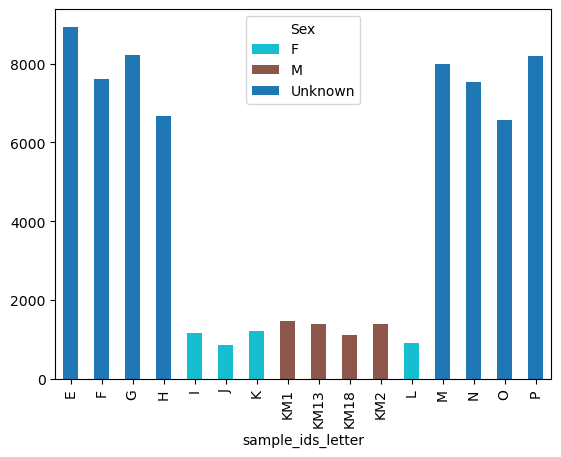

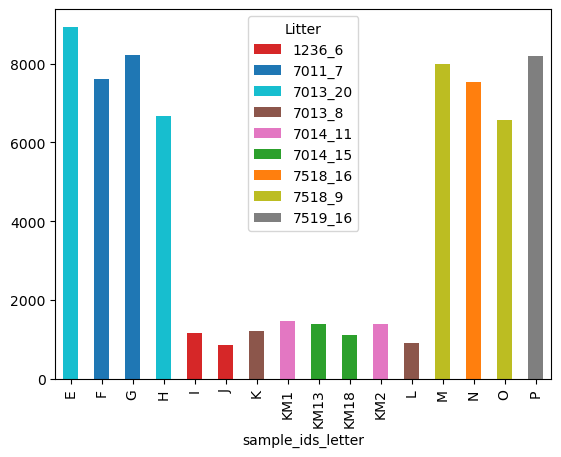

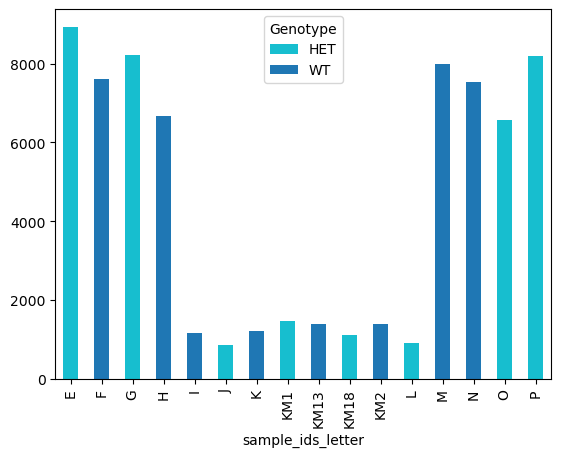

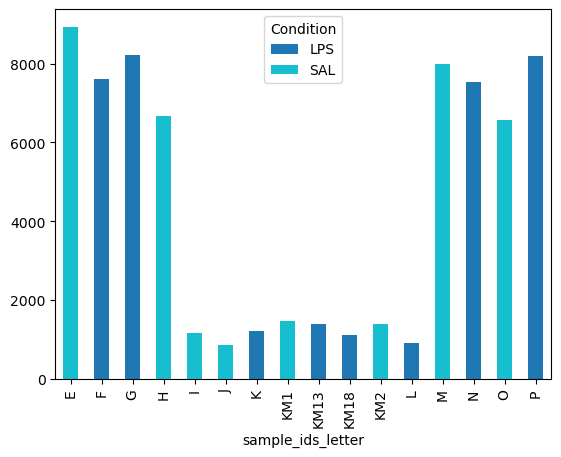

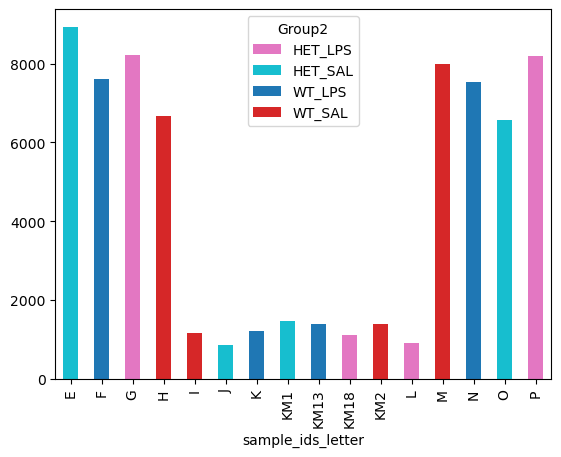

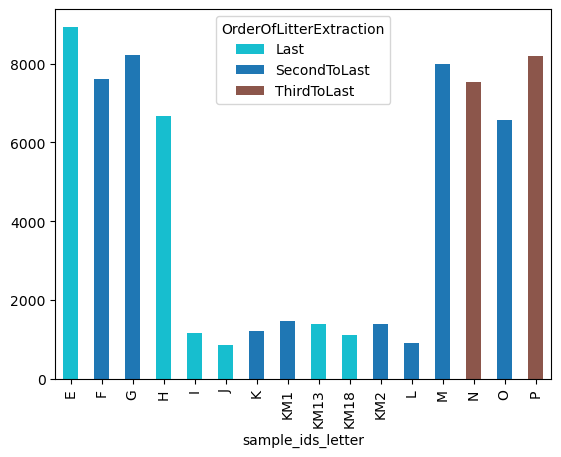

In [20]:
for col_interest in ['Sex', 'Litter', 'Genotype', 'Condition', 'Group2', 'OrderOfLitterExtraction']:
    col_levels = adata.obs[col_interest].unique()

    vis_meta_cellcount_stacked_bar(adata, meta_col=col_interest, 
                                dict_colors = dict(zip(col_levels, cm.get_cmap("tab10", len(col_levels)).colors )) )

## Preprocessing

I observe high MALAT1, which is inversely correlated with cellular health. This suggests that many of the cells in the dataset were stressed.

normalizing counts per cell
    finished (0:00:11)


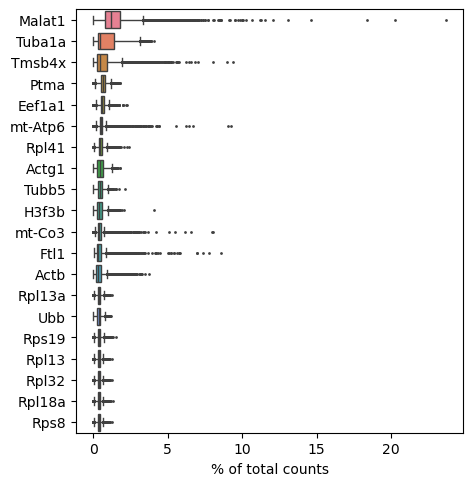

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Calculate Useful QC metrics

In [22]:
adata.var['gene_mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['gene_hsp'] = adata.var_names.str.startswith('Hsp')  # annotate the group of mitochondrial genes as 'mt'
adata.var['gene_ribo'] = adata.var_names.str.startswith(('Rpl', 'Rps'))  # annotate the group of mitochondrial genes as 'mt'
adata.var['gene_hemo'] = adata.var_names.str.startswith(('Hbb', 'Hba'))  # annotate the group of mitochondrial genes as 'mt'

sc.pp.calculate_qc_metrics(adata, qc_vars=['gene_mt', 'gene_hsp', 'gene_ribo', 'gene_hemo'], percent_top=None, log1p=False, inplace=True)

### How frequently were the Hemoglobin genes observed? 

This could be a symptom of contamination.

It seems like some of these Hemo genes (e.g. Hbb-y) are very widespread; 91% of cells have them.

I interpret this as evidence of widespread red blood cell contamination - better to remove cells that are PREDOMINANTLY this and to remove them from consideration when clustering or drop from matrix altogether.

In [23]:

hemo_genes = adata.var.index[adata.var['gene_hemo'] == True].to_list()
hemo_gene_mtx = sc.get.obs_df(adata, keys=hemo_genes)
zero_counts = np.sum(hemo_gene_mtx==0, axis=0)
relative_frequency = zero_counts / hemo_gene_mtx.shape[0]

print(relative_frequency)
print(f"Number of cells with no hemo counts: {np.sum(hemo_gene_mtx.sum(axis=1)==0)}")
print(f"Number of cells with some hemo counts: {np.sum(hemo_gene_mtx.sum(axis=1)>0)}")
print(f"Percent of cells with some hemo counts: {np.sum(hemo_gene_mtx.sum(axis=1)>0)/hemo_gene_mtx.shape[0] * 100}%")



Hbb-bt     0.768396
Hbb-bs     0.448873
Hbb-bh2    0.999593
Hbb-bh1    0.980372
Hbb-y      0.396673
Hba-x      0.914159
Hba-a1     0.572145
Hba-a2     0.638020
dtype: float64
Number of cells with no hemo counts: 5836
Number of cells with some hemo counts: 65389
Percent of cells with some hemo counts: 91.80624780624781%


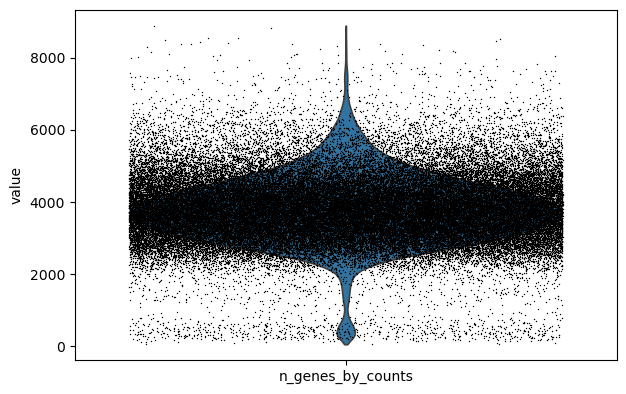

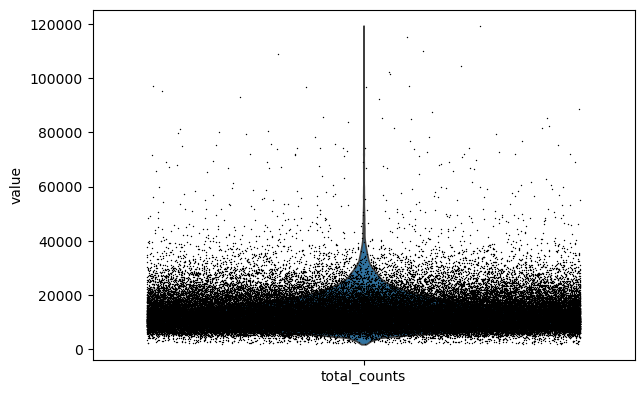

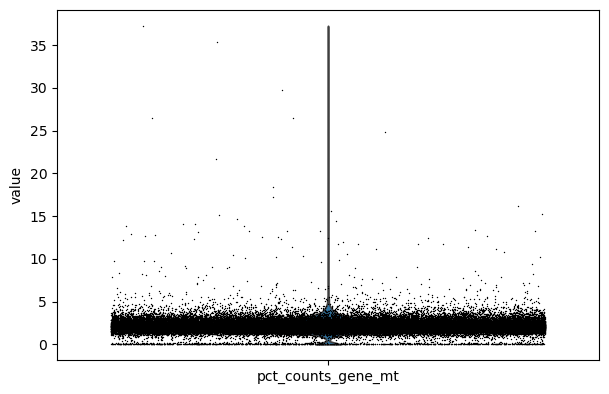

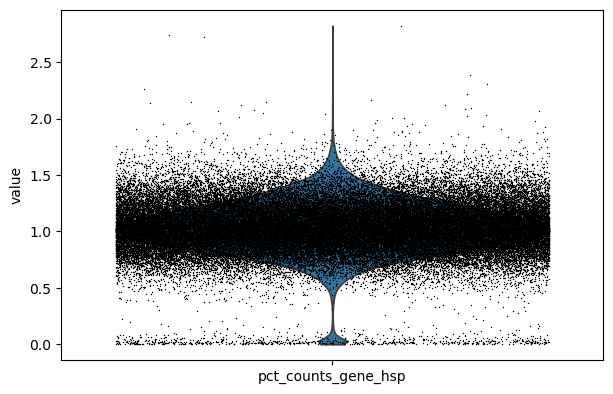

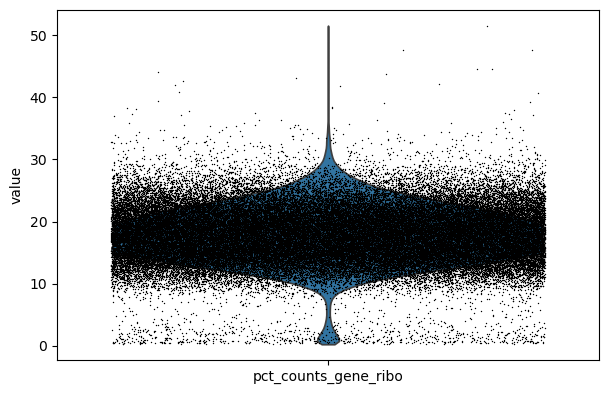

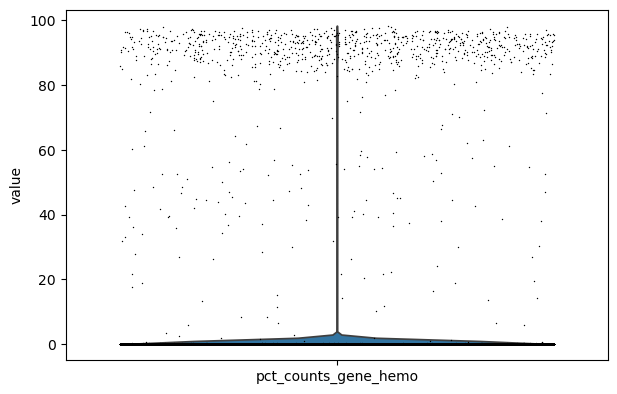

In [24]:
# accesses things in adata.obs
# ## broken with current seaborn update
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#              jitter=0.4, multi_panel=True)

# workaround until push fixed by the scanpy team
for c in ['n_genes_by_counts', 'total_counts', 'pct_counts_gene_mt', 'pct_counts_gene_hsp', 'pct_counts_gene_ribo', 
          'pct_counts_gene_hemo']:
    sc.pl.violin(adata, c,jitter=0.4, multi_panel=False)


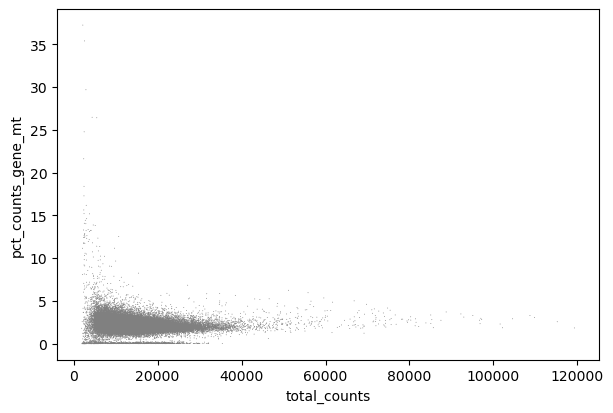

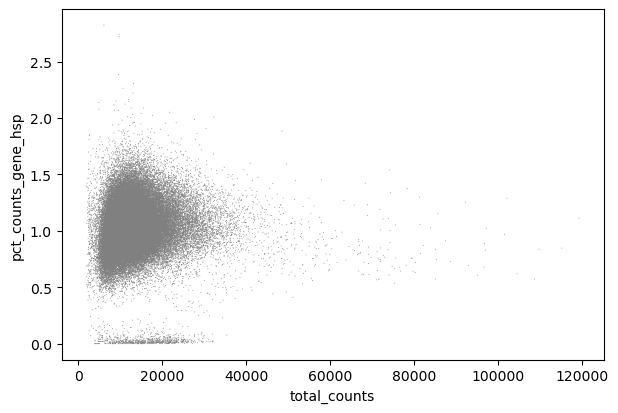

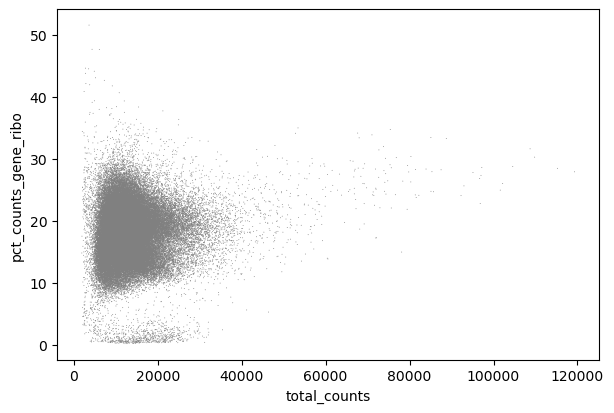

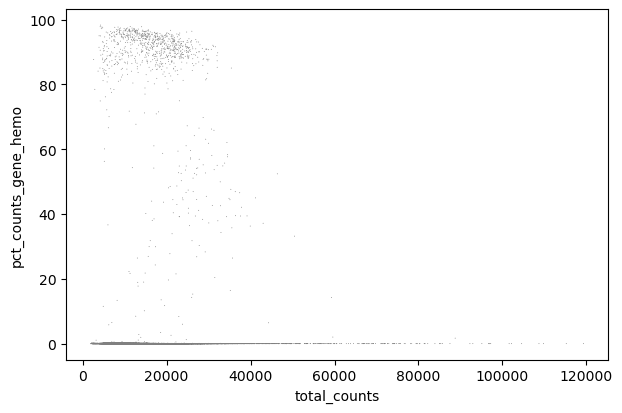

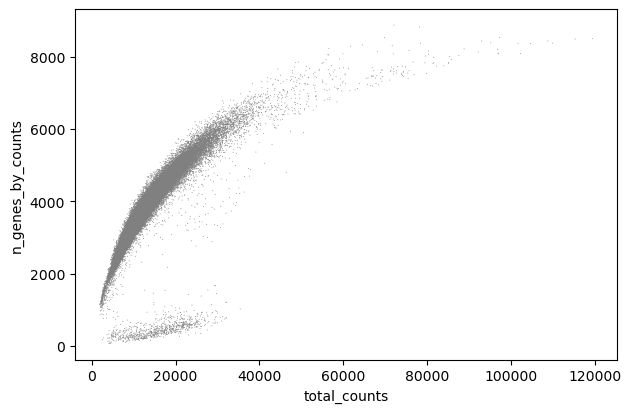

In [25]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_gene_mt')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_gene_hsp')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_gene_ribo')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_gene_hemo')

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [26]:
# Export data for later clustering exploration
adata.write(os.path.join(path_results, "adata_raw_unfiltered.h5ad"))

### Implement filtering

In [27]:
print(f"Gene meta: {', '.join(adata.var.columns)}")
print(f"Sample meta: {', '.join(adata.obs.columns)}")

Gene meta: gene_ids, msigdb_GOBP_SEX_DIFFERENTIATION.v2023.2.Mm, msigdb_GOCC_X_CHROMOSOME.v2023.2.Mm, msigdb_GOCC_SEX_CHROMOSOME.v2023.2.Mm, msigdb_GOBP_MALE_SEX_DETERMINATION.v2023.2.Mm, msigdb_GOBP_FEMALE_SEX_DIFFERENTIATION.v2023.2.Mm, msigdb_all_sex_dimorph_genes, gene_mt, gene_hsp, gene_ribo, gene_hemo, n_cells_by_counts, mean_counts, pct_dropout_by_counts, total_counts
Sample meta: sample_ids, PRESENT_raw, sample_ids_letter, SampleID, True ID, Litter, Pooled, Genotype, Condition, Group, Group2, CellsPerSample, SurgeryDate, Animal, OrderOfLitterExtraction, Sex, n_genes_by_counts, total_counts, total_counts_gene_mt, pct_counts_gene_mt, total_counts_gene_hsp, pct_counts_gene_hsp, total_counts_gene_ribo, pct_counts_gene_ribo, total_counts_gene_hemo, pct_counts_gene_hemo


In [28]:
# Scanpy methods filter in place and calculate needed statistics
# Throwing out only the very obviously bad ones
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs.n_genes_by_counts > 1000, :]

# !! TODO filter out hemo genes since these likely represent an artefact

filtered out 52 cells that have less than 200 genes expressed
filtered out 7871 genes that are detected in less than 3 cells


In [29]:
# Thresholds - cells pass if less than this number
## Thresholds chosen after review of best practices for similar cell types
filter_gene_ribo = 40 
filter_gene_hsp = 2
filter_gene_mt = 5
filter_gene_hemo = 0.5

In [30]:
# TODO illustrate filtering applied with each step

filter_dict = {'pct_counts_gene_ribo':filter_gene_ribo,
               'pct_counts_gene_hsp':filter_gene_hsp,
               'pct_counts_gene_mt':filter_gene_mt,
               'pct_counts_gene_hemo':filter_gene_hemo}

for key,value in filter_dict.items():
    adata = adata[adata.obs[key] < value]
    print(f"Size of matrix after filtering on {key}: {adata.obs.shape}")

Size of matrix after filtering on pct_counts_gene_ribo: (70408, 27)
Size of matrix after filtering on pct_counts_gene_hsp: (70383, 27)
Size of matrix after filtering on pct_counts_gene_mt: (70095, 27)
Size of matrix after filtering on pct_counts_gene_hemo: (69937, 27)


# Export data

In [31]:
# Export data that should represent real cells
adata.write(os.path.join(path_results, "adata_filtered.h5ad"))

In [32]:
# Save list of all sexually dimorphic genes
with open(os.path.join(path_results, 'all_sex_dimorph_genes.pkl'), 'wb') as file:
    pickle.dump(all_sex_dimorph_genes, file)